<a href="https://colab.research.google.com/github/sabeesh90/Advanced_Neural_Network_MosaicML/blob/main/Mosaic_ML_MNIST_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosaic ML

In [ ]:
!pip install mosaicml
!pip uninstall pillow
!pip install pillow-simd

!pip install torchcontrib

     |████████████████████████████████| 250 kB 7.8 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 332 kB 59.1 MB/s 
     |████████████████████████████████| 109 kB 67.7 MB/s 
     |████████████████████████████████| 546 kB 53.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PIL/*
    /usr/local/lib/python3.7/dist-packages/Pillow-7.1.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libfreetype-69f25d5e.so.6.17.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libjpeg-ba7bf5af.so.9.4.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblcms2-a6801db4.so.2.0.8
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblzma-99449165.so.5.2.5
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libopenjp2-b3d7668a.so.2.3.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libpng16-bedcb7ea.so.16.37.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libtiff-41910f6d.so.5.5.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebp-122bd20b.so.7.1.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebpdemux-2db559e5.so.2.0.6
    /usr/local/lib/python3.7/dist-packages/Pillow.li

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7532 sha256=a6e18a73263cea993fdddf7fc42afa406c5932c1cb23bb0af469d55361c54c46
  Stored in directory: /root/.cache/pip/wheels/91/58/d0/f03811c3e34e1f14031294b5f30d8693689972af874d1225b8
Successfully built torchcontrib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks/

MessageError: ignored

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms
import time

from torchcontrib.optim import SWA

# import composer
# from composer import DataloaderSpec
# from torchvision import datasets, transforms
# from composer import Trainer
# from composer.algorithms import LabelSmoothing, CutOut, BlurPool, scale_schedule, SWA,SAM, MixUp, SqueezeExcite,ScaleSchedule 


ModuleNotFoundError: ignored

In [ ]:
# trainer = Trainer(
#     model=m,
#     train_dataloader_spec=train_dataloader_spec,
#     eval_dataloader_spec=eval_dataloader_spec,
#     max_epochs=70,
#     train_batch_size=128,
#     eval_batch_size=128,
#     checkpoint_interval_unit="ep",
#     checkpoint_folder="squeeze_checkpoints",
#     checkpoint_interval=1,
#     # device =  'DeviceGPU',
#     # device ='cuda',
#     algorithms=[
#         SqueezeExcite(),
#         ScaleSchedule(2)
#     ],
# )

#### NORMAL MODEL

In [ ]:
dropout_value = 0.05
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 8

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),            
        ) # input_size = 26 , output_size = 24, 16 to 16 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(128),
        #     # nn.Dropout(dropout_value)
        # ) # input size  = 4,  output_size = 4
        # self.dropout3  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block - teacher
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)
        x = self.pool1(x)

        # transition block
        x = self.convblock3(x)
        x = self.convblock4(x)
        x  = self.dropout2(x)
        x = self.pool2(x)

         # global average pooling layer
        x = self.gap(x) 
        # classification        
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
basenet = BaseNet().to('cuda')
summary(basenet, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 32, 10, 10]           4,608
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
           Conv2d-12             [-1, 64, 8, 8]          18,432
             ReLU-13             [-1, 64, 8, 8]               0
      BatchNorm2d-14             [-1, 6

#### BASEMODEL  - 7K PARAMETERS

In [ ]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(0.03)
        ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block - teacher
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification
        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### BASELINE MODEL WITH DEPTH WISE  - 7.8K PARAMS

In [ ]:
dropout_value = 0.05
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            # nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),

            # depth wise trials
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),groups = 10, padding=0, bias=False),
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=13, kernel_size=(3, 3), padding=0, bias=False), # 14 in case of 13
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # 14 in case of 13
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(0.03)
        ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block - teacher
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification
        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
n = Net1().to('cuda')
summary(n, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]              90
            Conv2d-5           [-1, 12, 24, 24]             120
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 13, 10, 10]           1,170
             ReLU-12           [-1, 13, 10, 10]               0
      BatchNorm2d-13           [-1, 13, 10, 10]              26
           Conv2d-14             [-1, 1

#### depth wise with deeper network

In [ ]:
dropout_value = 0.05
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            # nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),

            # depth wise trials
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),groups = 10, padding=0, bias=False),
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), groups =10,padding=0, bias=False),
            nn.Conv2d(in_channels=10, out_channels=13, kernel_size=(1, 1), padding=0, bias=False), # 14 in case of 13
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3),groups = 13, padding=0, bias=False),
            nn.Conv2d(in_channels=13, out_channels=16, kernel_size=(1,1), padding=0, bias=False), # 14 in case of 13
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=1, bias=False),
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, groups = 15, bias=False),
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(0.03)
        ) # input size  = 4, output_size = 4

        
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block - teacher
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification
        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [ ]:
m = Net1()
summary(m, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]              90
            Conv2d-5           [-1, 12, 24, 24]             120
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]              90
           Conv2d-12           [-1, 13, 10, 10]             130
             ReLU-13           [-1, 13, 10, 10]               0
      BatchNorm2d-14           [-1, 13,

#### SMALLER MODEL - 5K

In [ ]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(15),
        #     # nn.Dropout(0.03)
        # ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block-assistant
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
k5_model = CNet().to("cuda")
summary(k5_model, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
           Dropout-7           [-1, 12, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]              96
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
           Conv2d-13             [-1, 16, 8, 8]           1,728
             ReLU-14             [-1, 1

In [ ]:
class CNet1(nn.Module):
    def __init__(self):
        super(CNet1, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            # nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            # depth wise convolution
            nn.Conv2d(in_channels=8, out_channels=8,groups = 8, kernel_size=(3, 3), padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(15),
        #     # nn.Dropout(0.03)
        # ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block-assistant
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
k5_model1 = CNet1().to("cuda")
summary(k5_model1, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]              72
            Conv2d-5           [-1, 12, 24, 24]              96
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 13, 10, 10]             936
             ReLU-12           [-1, 13, 10, 10]               0
      BatchNorm2d-13           [-1, 13, 10, 10]              26
           Conv2d-14             [-1, 1

#### SMALLEST MODEL

In [ ]:
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            # DEPTH WISE SEPERABLE COVOLUTION
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=0, bias=False),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
    ####################################### TRIAL BLOCK ##############################################################  
        # self.convblock6 = nn.Sequential(
        #     # DEPTH WISE SEPARABLE CONVOLUTIONS
        #     nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(15),
        #     # nn.Dropout(dropout_value)
        # ) # input size  = 4,  output_size = 4
        # self.dropout3  = nn.Sequential(nn.Dropout(0.17))

        #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16
        # self.flat = nn.Flatten()
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        # self.linear = nn.Linear(15,10)

    def forward(self, x):
        # first conv block - student
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 
        # x = self.flat(x)
        # classification        
        x = self.convblock8(x)
        # x = self.linear(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### SMALLEST MODEL 2

In [ ]:
class SimpleModel(composer.models.MosaicClassifier):
    def __init__(self, num_classes: int):
        module = nn.Sequential(
    ################################## 1 ST CONVOLUTIONAL BLOCK #####################################  
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),                                                                                #26x26 /8 

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),  #24x24/8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False), #24x24/12
            nn.ReLU(),
            nn.BatchNorm2d(12), 

            nn.Dropout(0.05),
    ################################### TRANSITION BLOCK #######################################
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),             #24x24/8
            nn.MaxPool2d(2, 2),                                                                               #12x12/8
    ################################## 2 ND CONVOLUTIONAL BLOCK #####################################            

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),  #10x10/8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),             #10x10/12
            nn.ReLU(),            
            nn.BatchNorm2d(12),

            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=0, bias=False), #8x8/12
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),             #8x8/16
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            
            nn.Dropout(0.17),
    ################################### TRANSITION BLOCK #######################################
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),            #8x8/12
            nn.MaxPool2d(2, 2),                                                                               #4x4/12
    ################################## 3 RD CONVOLUTIONAL BLOCK ##################################### 
            nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),#4x4/12
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),            #4x4/15
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            
            nn.Dropout(0.17),
    ################################### OUTPUT BLOCK ######################################        
            nn.AvgPool2d(kernel_size=4),                                                                      #1x1/15
            # nn.Linear(1,10),
            nn.Flatten(),
            # nn.Conv2d(in_channels=15, out_channels=num_classes, kernel_size=(1, 1), padding=0, bias=False),
            nn.Linear(15,10)
        )
        self.num_classes = num_classes
        super().__init__(module=module)

#### MODEL LOADING

In [ ]:
# m = SimpleModel(num_classes= 10).to('cuda')

In [ ]:
m = SNet().to('cuda')

In [ ]:
summary(m, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]              72
            Conv2d-5           [-1, 12, 24, 24]              96
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]              72
           Conv2d-12           [-1, 12, 10, 10]              96
             ReLU-13           [-1, 12, 10, 10]               0
      BatchNorm2d-14           [-1, 12,

#### MODEL AND DATASET LOADING


In [ ]:
use_cuda = True
train_dataloader_spec = DataloaderSpec(
    dataset=datasets.MNIST('/datasets/', train=True, transform=transforms.ToTensor(), download=True),
    drop_last=False,
    shuffle=True,
)

eval_dataloader_spec = DataloaderSpec(
    dataset=datasets.MNIST('/datasets/', train=False, transform=transforms.ToTensor()),
    drop_last=False,
    shuffle=False,
)




In [ ]:
use_cuda = True
transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])
train = datasets.MNIST('./data', train=True, download=True, transform=transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=transforms)
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
use_cuda = True
transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])
train = datasets.CIFAR10('./data10', train=True, download=True, transform=transforms)
test = datasets.CIFAR10('./data10', train=False, download=True, transform=transforms)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### SUBSET DATALOADING

In [ ]:
use_cuda = True
transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])
train = datasets.MNIST('./data2', train=True, download=True, transform=transforms)
test = datasets.MNIST('./data2', train=False, download=True, transform=transforms)

train_subset = list(range(0, 45000))
train_1 = torch.utils.data.Subset(train, train_subset)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train_1, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### WEIGHT TRANSFER EXPERIMENTS

In [ ]:
# from collections import OrderedDict

# path_ls = './label_smoothing_checkpoints/ep60.pt'
# state_items = torch.load(path_ls)['state']['model']

# new_state_dict = OrderedDict()
# for x,y in state_items.items():
#     name = x[7:]
#     new_state_dict[name] = y

# m.load_state_dict(new_state_dict)

module.module.0.weight convblock1.0.weight


In [ ]:
from collections import OrderedDict

path_ls = './label_smoothing_checkpoints/ep60.pt'
state_items = torch.load(path_ls)['state']['model']

new_state_dict = OrderedDict()
for (x,a) in zip(state_items.items(),m.state_dict()) :
    # name = x[7:]
    # new_state_dict[name] = y
    # comp_module_name, _ =
    saved_weights = x[1]
    saved_module_name = x[0]  
    act_module_name = a

    new_state_dict[act_module_name] = saved_weights

    # print(x[0].split(),a)
    # break

m.load_state_dict(new_state_dict)

<All keys matched successfully>

#### TRAIN FUNCTION

In [ ]:
def train(model):
    # print('working')
    model.train()
    pbar = tqdm(train_loader)
    device = 'cuda'
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      y_pred = model(data)
      loss = F.nll_loss(y_pred, target)
      loss.backward()
      optimizer.step()
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_loss += loss
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss)

    # return self.train_acc, self.train_loss

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    device = 'cuda'
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

def execute_model(model,save_best_model = False):
    for epoch in range(epochs):
        # best_accuracy = []
        
        print("EPOCH:", epoch)
        train(model)
        scheduler.step()
        test(model)
        if save_best_model == True:
            best_accuracy = max(test_acc)
            current_accuracy = test_acc[-1]
            print(best_accuracy,current_accuracy)
            if current_accuracy == best_accuracy or current_accuracy > best_accuracy:
                torch.save(model.state_dict(), path)
                print('Saving model here')

def plot_curves(a,log = False):    
    assert type(a) == str
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(train_acc)
    plt.plot(test_acc)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Accuracy Curves')
    plt.legend(['Train','Validation'])

    plt.subplot(122)
    plt.plot(train_losses)
    plt.plot(test_losses)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Loss Curves')
    plt.legend(['Train','Validation'])
    plt.show()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

#### TRAIN FUNCTION SUBSET

In [ ]:
def train(model):
    # print('working')
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      y_pred = model(data)
      loss = F.nll_loss(y_pred, target)
      loss.backward()
      optimizer.step()
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_loss += loss
    optimizer.swap_swa_sgd() # extra code to add the stochaism
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss)

    # return self.train_acc, self.train_loss

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

def execute_model(model,save_best_model = False):
    for epoch in range(epochs):
        print("EPOCH:", epoch)
        train(model)
        scheduler.step()
        test(model)
        if save_best_model == True:
            best_accuracy = max(test_acc)
            current_accuracy = test_acc[-1]
            print(best_accuracy,current_accuracy)
            if current_accuracy == best_accuracy or current_accuracy > best_accuracy:
                torch.save(model.state_dict(), path)
                print('Saving model here')

def plot_curves(a,log = False):    
    assert type(a) == str
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(train_acc)
    plt.plot(test_acc)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Accuracy Curves')
    plt.legend(['Train','Validation'])

    plt.subplot(122)
    plt.plot(train_losses)
    plt.plot(test_losses)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Loss Curves')
    plt.legend(['Train','Validation'])
    plt.show()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
epochs = 100
device = 'cuda'
opt = optim.Adam(m.parameters(), lr = 0.01)
optimizer = SWA(opt, swa_start=50, swa_freq=3, swa_lr=0.05)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/pyswa_mnist.pth'
execute_model(m, save_best_model=True)

EPOCH: 0


  0%|          | 0/352 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.13514575362205505 Batch_id=351 Accuracy=84.42: 100%|██████████| 352/352 [00:13<00:00, 25.30it/s]



Test set: Average loss: 6.1780, Accuracy: 1636/10000 (16.36%)

16.36 16.36
Saving model here
EPOCH: 1


Loss=0.1623702347278595 Batch_id=351 Accuracy=93.98: 100%|██████████| 352/352 [00:13<00:00, 25.58it/s]



Test set: Average loss: 3.8750, Accuracy: 3714/10000 (37.14%)

37.14 37.14
Saving model here
EPOCH: 2


Loss=0.08116363734006882 Batch_id=351 Accuracy=94.89: 100%|██████████| 352/352 [00:13<00:00, 25.41it/s]



Test set: Average loss: 7.3204, Accuracy: 1283/10000 (12.83%)

37.14 12.83
EPOCH: 3


Loss=0.08575272560119629 Batch_id=351 Accuracy=95.29: 100%|██████████| 352/352 [00:13<00:00, 25.45it/s]



Test set: Average loss: 4.7359, Accuracy: 2821/10000 (28.21%)

37.14 28.21
EPOCH: 4


Loss=0.10778459161520004 Batch_id=351 Accuracy=95.66: 100%|██████████| 352/352 [00:13<00:00, 25.39it/s]



Test set: Average loss: 1.0399, Accuracy: 6479/10000 (64.79%)

64.79 64.79
Saving model here
EPOCH: 5


Loss=0.27189144492149353 Batch_id=351 Accuracy=95.96: 100%|██████████| 352/352 [00:15<00:00, 22.73it/s]



Test set: Average loss: 1.7713, Accuracy: 5011/10000 (50.11%)

64.79 50.11
EPOCH: 6


Loss=0.08003214001655579 Batch_id=351 Accuracy=95.98: 100%|██████████| 352/352 [00:14<00:00, 25.14it/s]



Test set: Average loss: 0.7718, Accuracy: 7325/10000 (73.25%)

73.25 73.25
Saving model here
EPOCH: 7


Loss=0.20577695965766907 Batch_id=351 Accuracy=96.20: 100%|██████████| 352/352 [00:14<00:00, 25.03it/s]



Test set: Average loss: 6.6860, Accuracy: 1778/10000 (17.78%)

73.25 17.78
EPOCH: 8


Loss=0.06045835465192795 Batch_id=351 Accuracy=96.24: 100%|██████████| 352/352 [00:13<00:00, 25.20it/s]



Test set: Average loss: 2.5755, Accuracy: 2837/10000 (28.37%)

73.25 28.37
EPOCH: 9


Loss=0.3137270212173462 Batch_id=351 Accuracy=96.46: 100%|██████████| 352/352 [00:14<00:00, 25.12it/s]



Test set: Average loss: 5.2482, Accuracy: 2753/10000 (27.53%)

73.25 27.53
EPOCH: 10


Loss=0.11554417014122009 Batch_id=351 Accuracy=96.43: 100%|██████████| 352/352 [00:14<00:00, 24.93it/s]



Test set: Average loss: 0.9069, Accuracy: 7406/10000 (74.06%)

74.06 74.06
Saving model here
EPOCH: 11


Loss=0.1886400580406189 Batch_id=351 Accuracy=96.67: 100%|██████████| 352/352 [00:14<00:00, 24.91it/s]



Test set: Average loss: 0.4323, Accuracy: 8588/10000 (85.88%)

85.88 85.88
Saving model here
EPOCH: 12


Loss=0.0625610202550888 Batch_id=351 Accuracy=96.53: 100%|██████████| 352/352 [00:13<00:00, 25.15it/s]



Test set: Average loss: 1.6404, Accuracy: 5413/10000 (54.13%)

85.88 54.13
EPOCH: 13


Loss=0.1173611730337143 Batch_id=351 Accuracy=96.72: 100%|██████████| 352/352 [00:14<00:00, 24.75it/s]



Test set: Average loss: 1.3194, Accuracy: 6510/10000 (65.10%)

85.88 65.1
EPOCH: 14


Loss=0.0931302085518837 Batch_id=351 Accuracy=96.80: 100%|██████████| 352/352 [00:14<00:00, 24.98it/s]



Test set: Average loss: 0.5303, Accuracy: 8011/10000 (80.11%)

85.88 80.11
EPOCH: 15


Loss=0.10266578942537308 Batch_id=351 Accuracy=96.92: 100%|██████████| 352/352 [00:14<00:00, 24.96it/s]



Test set: Average loss: 1.7768, Accuracy: 6098/10000 (60.98%)

85.88 60.98
EPOCH: 16


Loss=0.015324986539781094 Batch_id=351 Accuracy=96.98: 100%|██████████| 352/352 [00:14<00:00, 24.68it/s]



Test set: Average loss: 0.3489, Accuracy: 8845/10000 (88.45%)

88.45 88.45
Saving model here
EPOCH: 17


Loss=0.07101725041866302 Batch_id=351 Accuracy=96.92: 100%|██████████| 352/352 [00:14<00:00, 24.86it/s]



Test set: Average loss: 1.3337, Accuracy: 6701/10000 (67.01%)

88.45 67.01
EPOCH: 18


Loss=0.054743990302085876 Batch_id=351 Accuracy=97.02: 100%|██████████| 352/352 [00:14<00:00, 24.92it/s]



Test set: Average loss: 2.2164, Accuracy: 4393/10000 (43.93%)

88.45 43.93
EPOCH: 19


Loss=0.07801829278469086 Batch_id=351 Accuracy=97.00: 100%|██████████| 352/352 [00:14<00:00, 24.82it/s]



Test set: Average loss: 0.5336, Accuracy: 8450/10000 (84.50%)

88.45 84.5
EPOCH: 20


Loss=0.12755759060382843 Batch_id=351 Accuracy=97.04: 100%|██████████| 352/352 [00:14<00:00, 24.58it/s]



Test set: Average loss: 0.3549, Accuracy: 8860/10000 (88.60%)

88.6 88.6
Saving model here
EPOCH: 21


Loss=0.046080734580755234 Batch_id=351 Accuracy=97.17: 100%|██████████| 352/352 [00:14<00:00, 24.79it/s]



Test set: Average loss: 0.5144, Accuracy: 8562/10000 (85.62%)

88.6 85.62
EPOCH: 22


Loss=0.054949887096881866 Batch_id=351 Accuracy=97.26: 100%|██████████| 352/352 [00:14<00:00, 24.86it/s]



Test set: Average loss: 0.8898, Accuracy: 7129/10000 (71.29%)

88.6 71.29
EPOCH: 23


Loss=0.09408777952194214 Batch_id=351 Accuracy=97.21: 100%|██████████| 352/352 [00:14<00:00, 24.66it/s]



Test set: Average loss: 0.1579, Accuracy: 9546/10000 (95.46%)

95.46 95.46
Saving model here
EPOCH: 24


Loss=0.03556250035762787 Batch_id=351 Accuracy=97.35: 100%|██████████| 352/352 [00:14<00:00, 24.74it/s]



Test set: Average loss: 0.8115, Accuracy: 7384/10000 (73.84%)

95.46 73.84
EPOCH: 25


Loss=0.20202070474624634 Batch_id=351 Accuracy=97.17: 100%|██████████| 352/352 [00:14<00:00, 25.06it/s]



Test set: Average loss: 0.1832, Accuracy: 9459/10000 (94.59%)

95.46 94.59
EPOCH: 26


Loss=0.08788469433784485 Batch_id=351 Accuracy=97.29: 100%|██████████| 352/352 [00:14<00:00, 24.61it/s]



Test set: Average loss: 1.3559, Accuracy: 5866/10000 (58.66%)

95.46 58.66
EPOCH: 27


Loss=0.3287287652492523 Batch_id=351 Accuracy=97.27: 100%|██████████| 352/352 [00:14<00:00, 24.85it/s]



Test set: Average loss: 0.5596, Accuracy: 8626/10000 (86.26%)

95.46 86.26
EPOCH: 28


Loss=0.027930239215493202 Batch_id=351 Accuracy=97.40: 100%|██████████| 352/352 [00:14<00:00, 24.51it/s]



Test set: Average loss: 0.2336, Accuracy: 9278/10000 (92.78%)

95.46 92.78
EPOCH: 29


Loss=0.15756607055664062 Batch_id=351 Accuracy=97.48: 100%|██████████| 352/352 [00:14<00:00, 24.93it/s]



Test set: Average loss: 0.6903, Accuracy: 8331/10000 (83.31%)

95.46 83.31
EPOCH: 30


Loss=0.04519461840391159 Batch_id=351 Accuracy=97.23: 100%|██████████| 352/352 [00:14<00:00, 24.84it/s]



Test set: Average loss: 0.4721, Accuracy: 8561/10000 (85.61%)

95.46 85.61
EPOCH: 31


Loss=0.10053817182779312 Batch_id=351 Accuracy=97.32: 100%|██████████| 352/352 [00:14<00:00, 24.74it/s]



Test set: Average loss: 0.6684, Accuracy: 8068/10000 (80.68%)

95.46 80.68
EPOCH: 32


Loss=0.06853792071342468 Batch_id=351 Accuracy=97.44: 100%|██████████| 352/352 [00:14<00:00, 24.73it/s]



Test set: Average loss: 0.2641, Accuracy: 9158/10000 (91.58%)

95.46 91.58
EPOCH: 33


Loss=0.10778115689754486 Batch_id=351 Accuracy=97.58: 100%|██████████| 352/352 [00:14<00:00, 24.59it/s]



Test set: Average loss: 0.9801, Accuracy: 7542/10000 (75.42%)

95.46 75.42
EPOCH: 34


Loss=0.07457248121500015 Batch_id=351 Accuracy=97.61: 100%|██████████| 352/352 [00:14<00:00, 24.58it/s]



Test set: Average loss: 0.1427, Accuracy: 9539/10000 (95.39%)

95.46 95.39
EPOCH: 35


Loss=0.03665432706475258 Batch_id=351 Accuracy=97.37: 100%|██████████| 352/352 [00:14<00:00, 24.22it/s]



Test set: Average loss: 0.7187, Accuracy: 8028/10000 (80.28%)

95.46 80.28
EPOCH: 36


Loss=0.07666714489459991 Batch_id=351 Accuracy=97.56: 100%|██████████| 352/352 [00:14<00:00, 24.35it/s]



Test set: Average loss: 0.2778, Accuracy: 9155/10000 (91.55%)

95.46 91.55
EPOCH: 37


Loss=0.010019046254456043 Batch_id=351 Accuracy=97.49: 100%|██████████| 352/352 [00:14<00:00, 24.38it/s]



Test set: Average loss: 0.8692, Accuracy: 7407/10000 (74.07%)

95.46 74.07
EPOCH: 38


Loss=0.07366441935300827 Batch_id=351 Accuracy=97.54: 100%|██████████| 352/352 [00:14<00:00, 24.53it/s]



Test set: Average loss: 0.0890, Accuracy: 9725/10000 (97.25%)

97.25 97.25
Saving model here
EPOCH: 39


Loss=0.14884859323501587 Batch_id=351 Accuracy=97.56: 100%|██████████| 352/352 [00:14<00:00, 24.34it/s]



Test set: Average loss: 2.1767, Accuracy: 5470/10000 (54.70%)

97.25 54.7
EPOCH: 40


Loss=0.1300661414861679 Batch_id=351 Accuracy=97.57: 100%|██████████| 352/352 [00:14<00:00, 24.26it/s]



Test set: Average loss: 0.5911, Accuracy: 8067/10000 (80.67%)

97.25 80.67
EPOCH: 41


Loss=0.04224634915590286 Batch_id=351 Accuracy=97.67: 100%|██████████| 352/352 [00:14<00:00, 24.38it/s]



Test set: Average loss: 0.2087, Accuracy: 9315/10000 (93.15%)

97.25 93.15
EPOCH: 42


Loss=0.02031305991113186 Batch_id=351 Accuracy=97.56: 100%|██████████| 352/352 [00:14<00:00, 24.11it/s]



Test set: Average loss: 0.6458, Accuracy: 8132/10000 (81.32%)

97.25 81.32
EPOCH: 43


Loss=0.05565920099616051 Batch_id=351 Accuracy=97.67: 100%|██████████| 352/352 [00:14<00:00, 24.45it/s]



Test set: Average loss: 3.5121, Accuracy: 4362/10000 (43.62%)

97.25 43.62
EPOCH: 44


Loss=0.04264393448829651 Batch_id=351 Accuracy=97.68: 100%|██████████| 352/352 [00:14<00:00, 24.15it/s]



Test set: Average loss: 1.4022, Accuracy: 7107/10000 (71.07%)

97.25 71.07
EPOCH: 45


Loss=0.10058204084634781 Batch_id=351 Accuracy=97.71: 100%|██████████| 352/352 [00:14<00:00, 24.08it/s]



Test set: Average loss: 0.3516, Accuracy: 8979/10000 (89.79%)

97.25 89.79
EPOCH: 46


Loss=0.09006381779909134 Batch_id=351 Accuracy=97.66: 100%|██████████| 352/352 [00:14<00:00, 23.97it/s]



Test set: Average loss: 0.5359, Accuracy: 8286/10000 (82.86%)

97.25 82.86
EPOCH: 47


Loss=0.07265788316726685 Batch_id=351 Accuracy=97.65: 100%|██████████| 352/352 [00:14<00:00, 24.06it/s]



Test set: Average loss: 0.7580, Accuracy: 8063/10000 (80.63%)

97.25 80.63
EPOCH: 48


Loss=0.0830678716301918 Batch_id=351 Accuracy=97.65: 100%|██████████| 352/352 [00:14<00:00, 23.96it/s]



Test set: Average loss: 0.2869, Accuracy: 9002/10000 (90.02%)

97.25 90.02
EPOCH: 49


Loss=0.16221779584884644 Batch_id=351 Accuracy=97.75: 100%|██████████| 352/352 [00:14<00:00, 24.34it/s]



Test set: Average loss: 0.2009, Accuracy: 9424/10000 (94.24%)

97.25 94.24
EPOCH: 50


Loss=0.024730056524276733 Batch_id=351 Accuracy=97.64: 100%|██████████| 352/352 [00:14<00:00, 24.08it/s]



Test set: Average loss: 0.2029, Accuracy: 9373/10000 (93.73%)

97.25 93.73
EPOCH: 51


Loss=0.09183564782142639 Batch_id=351 Accuracy=97.78: 100%|██████████| 352/352 [00:14<00:00, 24.43it/s]



Test set: Average loss: 0.2893, Accuracy: 9176/10000 (91.76%)

97.25 91.76
EPOCH: 52


Loss=0.0725444033741951 Batch_id=351 Accuracy=97.59: 100%|██████████| 352/352 [00:14<00:00, 24.46it/s]



Test set: Average loss: 0.4588, Accuracy: 8545/10000 (85.45%)

97.25 85.45
EPOCH: 53


Loss=0.04898902773857117 Batch_id=351 Accuracy=97.68: 100%|██████████| 352/352 [00:14<00:00, 24.26it/s]



Test set: Average loss: 0.1279, Accuracy: 9639/10000 (96.39%)

97.25 96.39
EPOCH: 54


Loss=0.07743033766746521 Batch_id=351 Accuracy=97.87: 100%|██████████| 352/352 [00:14<00:00, 24.21it/s]



Test set: Average loss: 0.1375, Accuracy: 9576/10000 (95.76%)

97.25 95.76
EPOCH: 55


Loss=0.05263640359044075 Batch_id=351 Accuracy=97.81: 100%|██████████| 352/352 [00:14<00:00, 24.22it/s]



Test set: Average loss: 0.5395, Accuracy: 8573/10000 (85.73%)

97.25 85.73
EPOCH: 56


Loss=0.07455052435398102 Batch_id=351 Accuracy=97.83: 100%|██████████| 352/352 [00:14<00:00, 24.17it/s]



Test set: Average loss: 0.3651, Accuracy: 8915/10000 (89.15%)

97.25 89.15
EPOCH: 57


Loss=0.08463925868272781 Batch_id=351 Accuracy=97.82: 100%|██████████| 352/352 [00:14<00:00, 23.81it/s]



Test set: Average loss: 0.2581, Accuracy: 9166/10000 (91.66%)

97.25 91.66
EPOCH: 58


Loss=0.07204229384660721 Batch_id=351 Accuracy=97.76: 100%|██████████| 352/352 [00:14<00:00, 24.10it/s]



Test set: Average loss: 0.1572, Accuracy: 9513/10000 (95.13%)

97.25 95.13
EPOCH: 59


Loss=0.054816097021102905 Batch_id=351 Accuracy=97.88: 100%|██████████| 352/352 [00:14<00:00, 24.13it/s]



Test set: Average loss: 0.8478, Accuracy: 7756/10000 (77.56%)

97.25 77.56
EPOCH: 60


Loss=0.07496581226587296 Batch_id=351 Accuracy=97.80: 100%|██████████| 352/352 [00:14<00:00, 24.20it/s]



Test set: Average loss: 0.2863, Accuracy: 9061/10000 (90.61%)

97.25 90.61
EPOCH: 61


Loss=0.047827694565057755 Batch_id=351 Accuracy=97.86: 100%|██████████| 352/352 [00:14<00:00, 23.96it/s]



Test set: Average loss: 0.8793, Accuracy: 7848/10000 (78.48%)

97.25 78.48
EPOCH: 62


Loss=0.04814360663294792 Batch_id=351 Accuracy=97.72: 100%|██████████| 352/352 [00:15<00:00, 23.45it/s]



Test set: Average loss: 0.1693, Accuracy: 9471/10000 (94.71%)

97.25 94.71
EPOCH: 63


Loss=0.08441680669784546 Batch_id=351 Accuracy=97.92: 100%|██████████| 352/352 [00:15<00:00, 23.29it/s]



Test set: Average loss: 0.8365, Accuracy: 7710/10000 (77.10%)

97.25 77.1
EPOCH: 64


Loss=0.08790406584739685 Batch_id=351 Accuracy=97.90: 100%|██████████| 352/352 [00:15<00:00, 23.29it/s]



Test set: Average loss: 0.2356, Accuracy: 9233/10000 (92.33%)

97.25 92.33
EPOCH: 65


Loss=0.050615713000297546 Batch_id=351 Accuracy=97.85: 100%|██████████| 352/352 [00:14<00:00, 23.97it/s]



Test set: Average loss: 0.1268, Accuracy: 9631/10000 (96.31%)

97.25 96.31
EPOCH: 66


Loss=0.032613594084978104 Batch_id=351 Accuracy=97.90: 100%|██████████| 352/352 [00:14<00:00, 24.06it/s]



Test set: Average loss: 0.6588, Accuracy: 7974/10000 (79.74%)

97.25 79.74
EPOCH: 67


Loss=0.10210715234279633 Batch_id=351 Accuracy=97.99: 100%|██████████| 352/352 [00:14<00:00, 24.02it/s]



Test set: Average loss: 0.7646, Accuracy: 8106/10000 (81.06%)

97.25 81.06
EPOCH: 68


Loss=0.033275529742240906 Batch_id=351 Accuracy=97.97: 100%|██████████| 352/352 [00:14<00:00, 23.84it/s]



Test set: Average loss: 0.3187, Accuracy: 9019/10000 (90.19%)

97.25 90.19
EPOCH: 69


Loss=0.07921874523162842 Batch_id=351 Accuracy=98.00: 100%|██████████| 352/352 [00:14<00:00, 23.92it/s]



Test set: Average loss: 0.9416, Accuracy: 7715/10000 (77.15%)

97.25 77.15
EPOCH: 70


Loss=0.04017798602581024 Batch_id=351 Accuracy=97.90: 100%|██████████| 352/352 [00:14<00:00, 23.83it/s]



Test set: Average loss: 0.1466, Accuracy: 9532/10000 (95.32%)

97.25 95.32
EPOCH: 71


Loss=0.021118193864822388 Batch_id=351 Accuracy=97.90: 100%|██████████| 352/352 [00:14<00:00, 23.95it/s]



Test set: Average loss: 0.5749, Accuracy: 8480/10000 (84.80%)

97.25 84.8
EPOCH: 72


Loss=0.005150511395186186 Batch_id=351 Accuracy=97.99: 100%|██████████| 352/352 [00:14<00:00, 23.93it/s]



Test set: Average loss: 0.3939, Accuracy: 8738/10000 (87.38%)

97.25 87.38
EPOCH: 73


Loss=0.10197512805461884 Batch_id=351 Accuracy=97.90: 100%|██████████| 352/352 [00:14<00:00, 23.74it/s]



Test set: Average loss: 0.2993, Accuracy: 9140/10000 (91.40%)

97.25 91.4
EPOCH: 74


Loss=0.02314073033630848 Batch_id=351 Accuracy=97.90: 100%|██████████| 352/352 [00:14<00:00, 23.90it/s]



Test set: Average loss: 0.2323, Accuracy: 9268/10000 (92.68%)

97.25 92.68
EPOCH: 75


Loss=0.38897475600242615 Batch_id=351 Accuracy=98.01: 100%|██████████| 352/352 [00:14<00:00, 23.67it/s]



Test set: Average loss: 0.2050, Accuracy: 9399/10000 (93.99%)

97.25 93.99
EPOCH: 76


Loss=0.044514402747154236 Batch_id=351 Accuracy=97.91: 100%|██████████| 352/352 [00:14<00:00, 23.68it/s]



Test set: Average loss: 0.3383, Accuracy: 8930/10000 (89.30%)

97.25 89.3
EPOCH: 77


Loss=0.11744502931833267 Batch_id=351 Accuracy=97.99: 100%|██████████| 352/352 [00:14<00:00, 23.70it/s]



Test set: Average loss: 0.3565, Accuracy: 8942/10000 (89.42%)

97.25 89.42
EPOCH: 78


Loss=0.09893939644098282 Batch_id=351 Accuracy=97.97: 100%|██████████| 352/352 [00:14<00:00, 23.88it/s]



Test set: Average loss: 0.2551, Accuracy: 9199/10000 (91.99%)

97.25 91.99
EPOCH: 79


Loss=0.09653875231742859 Batch_id=351 Accuracy=98.05: 100%|██████████| 352/352 [00:14<00:00, 23.68it/s]



Test set: Average loss: 0.3078, Accuracy: 9168/10000 (91.68%)

97.25 91.68
EPOCH: 80


Loss=0.03034301847219467 Batch_id=351 Accuracy=97.99: 100%|██████████| 352/352 [00:14<00:00, 23.76it/s]



Test set: Average loss: 0.7335, Accuracy: 7773/10000 (77.73%)

97.25 77.73
EPOCH: 81


Loss=0.03589803725481033 Batch_id=351 Accuracy=98.11: 100%|██████████| 352/352 [00:14<00:00, 23.77it/s]



Test set: Average loss: 0.5391, Accuracy: 8657/10000 (86.57%)

97.25 86.57
EPOCH: 82


Loss=0.020419826731085777 Batch_id=351 Accuracy=98.11: 100%|██████████| 352/352 [00:14<00:00, 23.93it/s]



Test set: Average loss: 0.3214, Accuracy: 8909/10000 (89.09%)

97.25 89.09
EPOCH: 83


Loss=0.012614483013749123 Batch_id=351 Accuracy=97.89: 100%|██████████| 352/352 [00:14<00:00, 23.84it/s]



Test set: Average loss: 0.2041, Accuracy: 9468/10000 (94.68%)

97.25 94.68
EPOCH: 84


Loss=0.05410466715693474 Batch_id=351 Accuracy=98.06: 100%|██████████| 352/352 [00:14<00:00, 23.85it/s]



Test set: Average loss: 0.4707, Accuracy: 8516/10000 (85.16%)

97.25 85.16
EPOCH: 85


Loss=0.0870797336101532 Batch_id=351 Accuracy=97.98: 100%|██████████| 352/352 [00:14<00:00, 23.85it/s]



Test set: Average loss: 0.3493, Accuracy: 9164/10000 (91.64%)

97.25 91.64
EPOCH: 86


Loss=0.1137290894985199 Batch_id=351 Accuracy=98.01: 100%|██████████| 352/352 [00:14<00:00, 23.68it/s]



Test set: Average loss: 1.4303, Accuracy: 6340/10000 (63.40%)

97.25 63.4
EPOCH: 87


Loss=0.047384683042764664 Batch_id=351 Accuracy=97.98: 100%|██████████| 352/352 [00:14<00:00, 24.04it/s]



Test set: Average loss: 0.5051, Accuracy: 8644/10000 (86.44%)

97.25 86.44
EPOCH: 88


Loss=0.01025333534926176 Batch_id=351 Accuracy=98.00: 100%|██████████| 352/352 [00:14<00:00, 23.79it/s]



Test set: Average loss: 0.1942, Accuracy: 9399/10000 (93.99%)

97.25 93.99
EPOCH: 89


Loss=0.11579852551221848 Batch_id=351 Accuracy=98.07: 100%|██████████| 352/352 [00:14<00:00, 24.06it/s]



Test set: Average loss: 0.4697, Accuracy: 8877/10000 (88.77%)

97.25 88.77
EPOCH: 90


Loss=0.060796961188316345 Batch_id=351 Accuracy=98.04: 100%|██████████| 352/352 [00:14<00:00, 23.74it/s]



Test set: Average loss: 0.2352, Accuracy: 9273/10000 (92.73%)

97.25 92.73
EPOCH: 91


Loss=0.1006179228425026 Batch_id=351 Accuracy=98.17: 100%|██████████| 352/352 [00:15<00:00, 23.41it/s]



Test set: Average loss: 0.1760, Accuracy: 9486/10000 (94.86%)

97.25 94.86
EPOCH: 92


Loss=0.011275280267000198 Batch_id=351 Accuracy=98.10: 100%|██████████| 352/352 [00:14<00:00, 23.71it/s]



Test set: Average loss: 0.2749, Accuracy: 9128/10000 (91.28%)

97.25 91.28
EPOCH: 93


Loss=0.05025400593876839 Batch_id=351 Accuracy=98.03: 100%|██████████| 352/352 [00:15<00:00, 23.45it/s]



Test set: Average loss: 0.3066, Accuracy: 9221/10000 (92.21%)

97.25 92.21
EPOCH: 94


Loss=0.0693429484963417 Batch_id=351 Accuracy=98.00: 100%|██████████| 352/352 [00:14<00:00, 23.53it/s]



Test set: Average loss: 0.4112, Accuracy: 8776/10000 (87.76%)

97.25 87.76
EPOCH: 95


Loss=0.018897399306297302 Batch_id=351 Accuracy=98.16: 100%|██████████| 352/352 [00:14<00:00, 23.62it/s]



Test set: Average loss: 0.2164, Accuracy: 9390/10000 (93.90%)

97.25 93.9
EPOCH: 96


Loss=0.006646326277405024 Batch_id=351 Accuracy=98.09: 100%|██████████| 352/352 [00:14<00:00, 23.93it/s]



Test set: Average loss: 0.1291, Accuracy: 9569/10000 (95.69%)

97.25 95.69
EPOCH: 97


Loss=0.09079921990633011 Batch_id=351 Accuracy=98.11: 100%|██████████| 352/352 [00:14<00:00, 23.65it/s]



Test set: Average loss: 0.4824, Accuracy: 8669/10000 (86.69%)

97.25 86.69
EPOCH: 98


Loss=0.05752250924706459 Batch_id=351 Accuracy=97.95: 100%|██████████| 352/352 [00:14<00:00, 23.68it/s]



Test set: Average loss: 0.2240, Accuracy: 9288/10000 (92.88%)

97.25 92.88
EPOCH: 99


Loss=0.035918623208999634 Batch_id=351 Accuracy=98.19: 100%|██████████| 352/352 [00:14<00:00, 23.55it/s]



Test set: Average loss: 3.0992, Accuracy: 5779/10000 (57.79%)

97.25 57.79


#### 7K WITH DW TRAINING WITH EVALUATION

In [ ]:
time.time()

1638769815.752612

In [ ]:
# RUNNING THE INFERENCEC TIME ON A CPU
test_losses = []
test_acc =[]
def test1(model):
    model.eval()
    test_loss = 0
    correct = 0
    # device = 'cuda'
    time_list = []
    with torch.no_grad():
        for data, target in test_loader:
            # data, target = data.to(device), target.to(device)
            start = time.time()
            output = model(data)
            end = time.time()
            interval = end-start
            time_list.append(interval)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    total_time = sum(time_list)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print(f'time taken is {total_time}')

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
test_model = Net().to('cuda')
summary(test_model, input_size = (1,28,28))

epochs = 50
optimizer = optim.Adam(test_model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/mosaic_7k_dw.pth'



RuntimeError: ignored

In [ ]:
execute_model(test_model, save_best_model=True)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1082153394818306 Batch_id=468 Accuracy=93.60: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]



Test set: Average loss: 0.0614, Accuracy: 9818/10000 (98.18%)

98.18 98.18
Saving model here
EPOCH: 1


Loss=0.02054537832736969 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]



Test set: Average loss: 0.0555, Accuracy: 9814/10000 (98.14%)

98.18 98.14
EPOCH: 2


Loss=0.0875418409705162 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]



Test set: Average loss: 0.0368, Accuracy: 9879/10000 (98.79%)

98.79 98.79
Saving model here
EPOCH: 3


Loss=0.02730736881494522 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]



Test set: Average loss: 0.0384, Accuracy: 9884/10000 (98.84%)

98.84 98.84
Saving model here
EPOCH: 4


Loss=0.025228897109627724 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]



Test set: Average loss: 0.0416, Accuracy: 9865/10000 (98.65%)

98.84 98.65
EPOCH: 5


Loss=0.06000388041138649 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]



Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

99.34 99.34
Saving model here
EPOCH: 6


Loss=0.001279215794056654 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]



Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

99.35 99.35
Saving model here
EPOCH: 7


Loss=0.014887847937643528 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 8


Loss=0.13382670283317566 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]



Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

99.35 99.34
EPOCH: 9


Loss=0.08737765997648239 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]



Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

99.42 99.42
Saving model here
EPOCH: 10


Loss=0.050947513431310654 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

99.44 99.44
Saving model here
EPOCH: 11


Loss=0.08939076215028763 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.56it/s]



Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

99.44 99.4
EPOCH: 12


Loss=0.060498252511024475 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]



Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

99.44 99.43
EPOCH: 13


Loss=0.015667391940951347 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]



Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

99.44 99.42
EPOCH: 14


Loss=0.07250838726758957 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

99.44 99.44
Saving model here
EPOCH: 15


Loss=0.018782032653689384 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 36.83it/s]



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

99.44 99.43
EPOCH: 16


Loss=0.011412869207561016 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]



Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

99.44 99.42
EPOCH: 17


Loss=0.004648513626307249 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

99.44 99.43
EPOCH: 18


Loss=0.017759809270501137 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]



Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

99.44 99.43
EPOCH: 19


Loss=0.04964422807097435 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s]



Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

99.44 99.41
EPOCH: 20


Loss=0.04003634676337242 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:12<00:00, 36.41it/s]



Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

99.45 99.45
Saving model here
EPOCH: 21


Loss=0.05418994650244713 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:12<00:00, 36.70it/s]



Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

99.45 99.44
EPOCH: 22


Loss=0.03063797391951084 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]



Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

99.45 99.44
EPOCH: 23


Loss=0.008022727444767952 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 36.43it/s]



Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

99.45 99.42
EPOCH: 24


Loss=0.010450811125338078 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]



Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

99.45 99.44
EPOCH: 25


Loss=0.031612563878297806 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 36.77it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

99.45 99.45
Saving model here
EPOCH: 26


Loss=0.059387292712926865 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

99.45 99.44
EPOCH: 27


Loss=0.017665257677435875 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]



Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

99.45 99.43
EPOCH: 28


Loss=0.012305264361202717 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]



Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

99.45 99.43
EPOCH: 29


Loss=0.0024973589461296797 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]



Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

99.45 99.44
EPOCH: 30


Loss=0.027332833036780357 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:12<00:00, 37.02it/s]



Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

99.45 99.44
EPOCH: 31


Loss=0.007543714251369238 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:12<00:00, 36.87it/s]



Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

99.46 99.46
Saving model here
EPOCH: 32


Loss=0.01399508398026228 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:12<00:00, 36.87it/s]



Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

99.46 99.44
EPOCH: 33


Loss=0.00539654865860939 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.08it/s]



Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

99.46 99.44
EPOCH: 34


Loss=0.014303344301879406 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

99.46 99.43
EPOCH: 35


Loss=0.004373711068183184 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

99.46 99.44
EPOCH: 36


Loss=0.0016808713553473353 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

99.46 99.41
EPOCH: 37


Loss=0.00405402947217226 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]



Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

99.46 99.44
EPOCH: 38


Loss=0.005847516935318708 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]



Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

99.46 99.42
EPOCH: 39


Loss=0.004465402569621801 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

99.46 99.42
EPOCH: 40


Loss=0.032483313232660294 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]



Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

99.46 99.42
EPOCH: 41


Loss=0.014879980124533176 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]



Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

99.46 99.46
Saving model here
EPOCH: 42


Loss=0.018985634669661522 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]



Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

99.46 99.46
Saving model here
EPOCH: 43


Loss=0.002994045615196228 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]



Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

99.46 99.43
EPOCH: 44


Loss=0.00778867257758975 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

99.46 99.41
EPOCH: 45


Loss=0.002465047175064683 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

99.46 99.45
EPOCH: 46


Loss=0.005003333557397127 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

99.46 99.44
EPOCH: 47


Loss=0.008983730338513851 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]



Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

99.46 99.44
EPOCH: 48


Loss=0.033340808004140854 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]



Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

99.46 99.41
EPOCH: 49


Loss=0.002529869554564357 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 35.99it/s]



Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

99.46 99.44


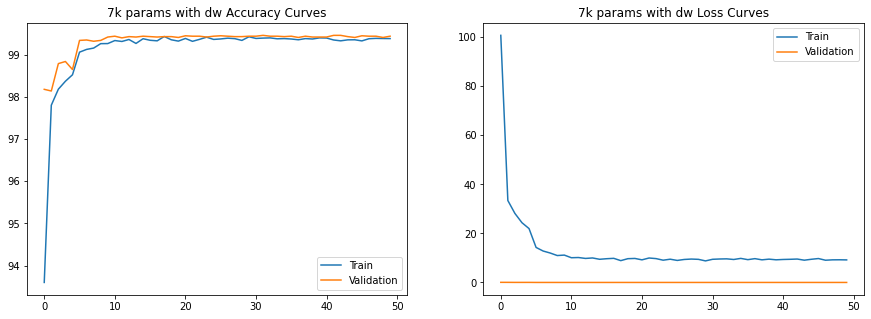

In [ ]:
plot_curves('7k params with dw',test_model)

#### 7K MODEL WITH 7.6 K PARAMS


In [ ]:
test_model = Net1().to('cuda')
summary(test_model, input_size = (1,28,28))

epochs = 50
optimizer = optim.Adam(test_model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/mosaic_7k_dw_new.pth'


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]              90
            Conv2d-5           [-1, 12, 24, 24]             120
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 13, 10, 10]           1,170
             ReLU-12           [-1, 13, 10, 10]               0
      BatchNorm2d-13           [-1, 13, 10, 10]              26
           Conv2d-14             [-1, 1

In [ ]:
execute_model(test_model, save_best_model=True)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.13090483844280243 Batch_id=468 Accuracy=93.51: 100%|██████████| 469/469 [00:11<00:00, 40.62it/s]



Test set: Average loss: 0.1281, Accuracy: 9607/10000 (96.07%)

96.07 96.07
Saving model here
EPOCH: 1


Loss=0.06565754115581512 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]



Test set: Average loss: 0.0567, Accuracy: 9813/10000 (98.13%)

98.13 98.13
Saving model here
EPOCH: 2


Loss=0.031689006835222244 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s]



Test set: Average loss: 0.0488, Accuracy: 9849/10000 (98.49%)

98.49 98.49
Saving model here
EPOCH: 3


Loss=0.175955668091774 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:11<00:00, 40.37it/s]



Test set: Average loss: 0.0382, Accuracy: 9887/10000 (98.87%)

98.87 98.87
Saving model here
EPOCH: 4


Loss=0.07044311612844467 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]



Test set: Average loss: 0.0393, Accuracy: 9879/10000 (98.79%)

98.87 98.79
EPOCH: 5


Loss=0.008538560010492802 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 40.44it/s]



Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

99.21 99.21
Saving model here
EPOCH: 6


Loss=0.041385192424058914 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 40.64it/s]



Test set: Average loss: 0.0253, Accuracy: 9911/10000 (99.11%)

99.21 99.11
EPOCH: 7


Loss=0.018815508112311363 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]



Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

99.22 99.22
Saving model here
EPOCH: 8


Loss=0.004526353906840086 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]



Test set: Average loss: 0.0237, Accuracy: 9919/10000 (99.19%)

99.22 99.19
EPOCH: 9


Loss=0.003062059171497822 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 40.23it/s]



Test set: Average loss: 0.0247, Accuracy: 9925/10000 (99.25%)

99.25 99.25
Saving model here
EPOCH: 10


Loss=0.008385790511965752 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.52it/s]



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

99.25 99.24
EPOCH: 11


Loss=0.08226577192544937 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

99.25 99.25
Saving model here
EPOCH: 12


Loss=0.009610921144485474 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]



Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

99.25 99.2
EPOCH: 13


Loss=0.002387305023148656 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.78it/s]



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

99.28 99.28
Saving model here
EPOCH: 14


Loss=0.006180583033710718 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]



Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

99.28 99.28
Saving model here
EPOCH: 15


Loss=0.007284469902515411 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.09it/s]



Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

99.28 99.27
EPOCH: 16


Loss=0.05470110476016998 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 40.71it/s]



Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

99.31 99.31
Saving model here
EPOCH: 17


Loss=0.006730444263666868 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 40.21it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 18


Loss=0.008591183461248875 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 40.79it/s]



Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

99.31 99.26
EPOCH: 19


Loss=0.06954629719257355 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]



Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 20


Loss=0.013369708321988583 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]



Test set: Average loss: 0.0232, Accuracy: 9926/10000 (99.26%)

99.31 99.26
EPOCH: 21


Loss=0.012492910958826542 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.84it/s]



Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

99.31 99.3
EPOCH: 22


Loss=0.023412197828292847 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]



Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 23


Loss=0.004855922888964415 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.03it/s]



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

99.31 99.28
EPOCH: 24


Loss=0.005448854994028807 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s]



Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 25


Loss=0.005849994253367186 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.14it/s]



Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

99.31 99.29
EPOCH: 26


Loss=0.006535604130476713 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 27


Loss=0.00594748929142952 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]



Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

99.31 99.28
EPOCH: 28


Loss=0.0019165356643497944 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.33it/s]



Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 29


Loss=0.006686723325401545 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]



Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 30


Loss=0.13173054158687592 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s]



Test set: Average loss: 0.0232, Accuracy: 9926/10000 (99.26%)

99.31 99.26
EPOCH: 31


Loss=0.018181422725319862 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]



Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

99.31 99.24
EPOCH: 32


Loss=0.004015788435935974 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

99.31 99.28
EPOCH: 33


Loss=0.08537200093269348 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]



Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

99.31 99.29
EPOCH: 34


Loss=0.020938977599143982 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 38.63it/s]



Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

99.31 99.26
EPOCH: 35


Loss=0.02247251570224762 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 39.71it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

99.31 99.26
EPOCH: 36


Loss=0.012650396674871445 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]



Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 37


Loss=0.03469930216670036 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 38


Loss=0.047761380672454834 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 39


Loss=0.012024745345115662 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 39.54it/s]



Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

99.31 99.25
EPOCH: 40


Loss=0.028406566008925438 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 39.55it/s]



Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 41


Loss=0.008627836592495441 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 39.66it/s]



Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

99.31 99.3
EPOCH: 42


Loss=0.015173579566180706 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

99.31 99.28
EPOCH: 43


Loss=0.015255617909133434 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]



Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 44


Loss=0.006850117817521095 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.82it/s]



Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

99.31 99.27
EPOCH: 45


Loss=0.007182084023952484 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 39.45it/s]



Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

99.33 99.33
Saving model here
EPOCH: 46


Loss=0.0022405392955988646 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.31it/s]



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

99.33 99.27
EPOCH: 47


Loss=0.002883447101339698 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 39.10it/s]



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

99.33 99.3
EPOCH: 48


Loss=0.009814745746552944 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.21it/s]



Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

99.33 99.26
EPOCH: 49


Loss=0.045463334769010544 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.49it/s]



Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

99.33 99.26


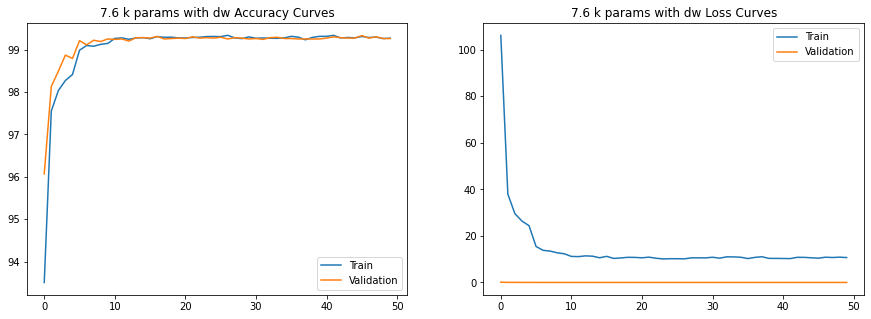

In [ ]:
plot_curves('7.6 k params with dw',test_model)

#### 5.6K MODEL WITH DEPTHWISE CONV 

In [ ]:
test_model = CNet1().to('cuda')
summary(test_model, input_size = (1,28,28))

epochs = 50
optimizer = optim.Adam(test_model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/mosaic_5K_dw_new.pth'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]              72
            Conv2d-5           [-1, 12, 24, 24]              96
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 13, 10, 10]             936
             ReLU-12           [-1, 13, 10, 10]               0
      BatchNorm2d-13           [-1, 13, 10, 10]              26
           Conv2d-14             [-1, 1

In [ ]:
execute_model(test_model, save_best_model=True)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.13055835664272308 Batch_id=468 Accuracy=92.44: 100%|██████████| 469/469 [00:11<00:00, 39.51it/s]



Test set: Average loss: 0.1017, Accuracy: 9651/10000 (96.51%)

96.51 96.51
Saving model here
EPOCH: 1


Loss=0.04787528142333031 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:12<00:00, 38.89it/s]



Test set: Average loss: 0.0436, Accuracy: 9868/10000 (98.68%)

98.68 98.68
Saving model here
EPOCH: 2


Loss=0.019855692982673645 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:11<00:00, 39.74it/s]



Test set: Average loss: 0.0483, Accuracy: 9838/10000 (98.38%)

98.68 98.38
EPOCH: 3


Loss=0.057521283626556396 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:11<00:00, 40.15it/s]



Test set: Average loss: 0.0451, Accuracy: 9859/10000 (98.59%)

98.68 98.59
EPOCH: 4


Loss=0.11048400402069092 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:11<00:00, 39.38it/s]



Test set: Average loss: 0.0370, Accuracy: 9882/10000 (98.82%)

98.82 98.82
Saving model here
EPOCH: 5


Loss=0.0676373764872551 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]



Test set: Average loss: 0.0262, Accuracy: 9914/10000 (99.14%)

99.14 99.14
Saving model here
EPOCH: 6


Loss=0.04417817294597626 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 39.40it/s]



Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 7


Loss=0.05187194049358368 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 39.51it/s]



Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

99.27 99.24
EPOCH: 8


Loss=0.002177296206355095 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 9


Loss=0.013960727490484715 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]



Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

99.27 99.2
EPOCH: 10


Loss=0.012264303863048553 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 39.12it/s]



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 11


Loss=0.02797161042690277 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]



Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

99.29 99.29
Saving model here
EPOCH: 12


Loss=0.04378479719161987 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 39.10it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

99.29 99.25
EPOCH: 13


Loss=0.018713654950261116 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 39.35it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

99.29 99.26
EPOCH: 14


Loss=0.026468550786376 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

99.29 99.27
EPOCH: 15


Loss=0.009634794667363167 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.68it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

99.29 99.26
EPOCH: 16


Loss=0.011882253922522068 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 39.42it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 17


Loss=0.0478571355342865 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]



Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 18


Loss=0.17101234197616577 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]



Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

99.3 99.25
EPOCH: 19


Loss=0.06769631057977676 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]



Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 20


Loss=0.012907758355140686 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.26it/s]



Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

99.3 99.25
EPOCH: 21


Loss=0.003455857513472438 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]



Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 22


Loss=0.004422960337251425 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 37.94it/s]



Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 23


Loss=0.01312565803527832 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 24


Loss=0.004812197759747505 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]



Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

99.3 99.26
EPOCH: 25


Loss=0.030738502740859985 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]



Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

99.3 99.26
EPOCH: 26


Loss=0.018104668706655502 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.60it/s]



Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 27


Loss=0.04104657843708992 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]



Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 28


Loss=0.002122580772265792 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]



Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

99.3 99.29
EPOCH: 29


Loss=0.01464646216481924 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.83it/s]



Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 30


Loss=0.009402308613061905 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 37.20it/s]



Test set: Average loss: 0.0221, Accuracy: 9923/10000 (99.23%)

99.3 99.23
EPOCH: 31


Loss=0.033617518842220306 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]



Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

99.3 99.29
EPOCH: 32


Loss=0.003985182847827673 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 38.82it/s]



Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 33


Loss=0.023649848997592926 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 38.97it/s]



Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.26%)

99.3 99.26
EPOCH: 34


Loss=0.009338229894638062 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]



Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 35


Loss=0.0156644769012928 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]



Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 36


Loss=0.12693272531032562 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 39.04it/s]



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 37


Loss=0.042733240872621536 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.90it/s]



Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

99.3 99.26
EPOCH: 38


Loss=0.10957914590835571 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 39.39it/s]



Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

99.3 99.26
EPOCH: 39


Loss=0.0208726916462183 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.19it/s]



Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

99.3 99.25
EPOCH: 40


Loss=0.04985083267092705 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.75it/s]



Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 41


Loss=0.07496066391468048 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.63it/s]



Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

99.3 99.25
EPOCH: 42


Loss=0.019618330523371696 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]



Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 43


Loss=0.008292394690215588 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 38.50it/s]



Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

99.3 99.29
EPOCH: 44


Loss=0.04374505206942558 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 39.05it/s]



Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 45


Loss=0.019316690042614937 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.40it/s]



Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 46


Loss=0.06526999920606613 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

99.3 99.29
EPOCH: 47


Loss=0.01877213642001152 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 37.91it/s]



Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 48


Loss=0.010773216374218464 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 37.83it/s]



Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

99.3 99.27
EPOCH: 49


Loss=0.10083002597093582 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]



Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)

99.3 99.27


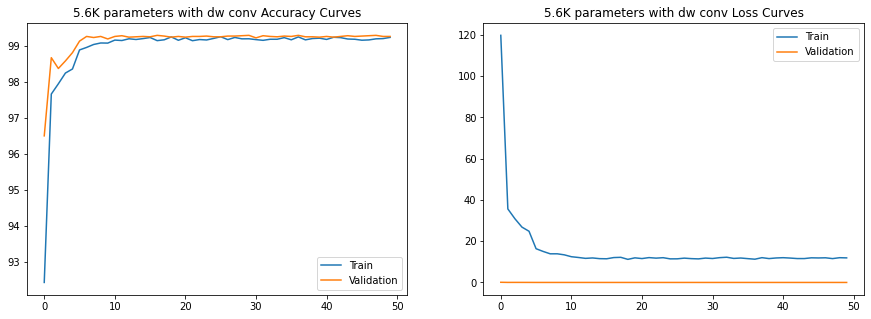

In [ ]:
plot_curves('5.6K parameters with dw conv')

#### BASENET TRAINING

In [ ]:
epochs = 50
optimizer = optim.Adam(basenet.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/basenet25k.pth'


In [ ]:
execute_model(basenet, save_best_model=True)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.00558740459382534 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:11<00:00, 42.58it/s]



Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

99.35 99.29
EPOCH: 1


Loss=0.0005575611721724272 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 43.27it/s]



Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

99.35 99.29
EPOCH: 2


Loss=0.008801541291177273 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:11<00:00, 42.39it/s]



Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 3


Loss=0.005467440467327833 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:11<00:00, 42.39it/s]



Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

99.35 99.29
EPOCH: 4


Loss=0.02612931840121746 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]



Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 5


Loss=0.001837934018112719 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s]



Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 6


Loss=0.014143336564302444 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:11<00:00, 42.52it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 7


Loss=0.00477896723896265 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 42.31it/s]



Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

99.35 99.35
Saving model here
EPOCH: 8


Loss=0.004245364107191563 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.58it/s]



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 9


Loss=0.0023852328304201365 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 42.44it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 10


Loss=0.023078732192516327 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 11


Loss=0.001029090373776853 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 12


Loss=0.0019513815641403198 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s]



Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 13


Loss=0.0014543962897732854 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:10<00:00, 42.96it/s]



Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

99.35 99.34
EPOCH: 14


Loss=0.005384864751249552 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.81it/s]



Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

99.35 99.34
EPOCH: 15


Loss=0.0007527198176831007 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 41.40it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 16


Loss=0.0005670698010362685 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 42.33it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 17


Loss=0.011619067750871181 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:11<00:00, 41.93it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 18


Loss=0.010014846920967102 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.18it/s]



Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 19


Loss=0.0011635733535513282 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.99it/s]



Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

99.35 99.34
EPOCH: 20


Loss=0.02658594399690628 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.25it/s]



Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 21


Loss=0.012752990238368511 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s]



Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 22


Loss=0.006269669160246849 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.75it/s]



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 23


Loss=0.00241866591386497 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.17it/s]



Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 24


Loss=0.0014789925189688802 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.96it/s]



Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 25


Loss=0.03143145143985748 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.34it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 26


Loss=0.004307493567466736 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:11<00:00, 41.55it/s]



Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 27


Loss=0.0007890099077485502 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.41it/s]



Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 28


Loss=0.0028155960608273745 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]



Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 29


Loss=0.0015522785251960158 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]



Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

99.35 99.29
EPOCH: 30


Loss=0.0015475740656256676 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.71it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 31


Loss=0.0021144957281649113 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.19it/s]



Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 32


Loss=0.0050553795881569386 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 40.97it/s]



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 33


Loss=0.004191295709460974 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s]



Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

99.35 99.34
EPOCH: 34


Loss=0.010423672385513783 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 40.53it/s]



Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

99.35 99.35
Saving model here
EPOCH: 35


Loss=0.002116902032867074 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s]



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 36


Loss=0.003453887300565839 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]



Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

99.35 99.27
EPOCH: 37


Loss=0.0029388591647148132 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 41.27it/s]



Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

99.35 99.35
Saving model here
EPOCH: 38


Loss=0.005716720595955849 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s]



Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 39


Loss=0.0008876295760273933 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.05it/s]



Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 40


Loss=0.0008701427723281085 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 41


Loss=0.009804162196815014 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 40.55it/s]



Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 42


Loss=0.02477221190929413 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:12<00:00, 39.05it/s]



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 43


Loss=0.0011001399252563715 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]



Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 44


Loss=0.003773842239752412 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:11<00:00, 41.25it/s]



Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

99.35 99.33
EPOCH: 45


Loss=0.0025346192996948957 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 40.21it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 46


Loss=0.004092139657586813 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:11<00:00, 40.44it/s]



Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

99.35 99.32
EPOCH: 47


Loss=0.0013715067179873586 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]



Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

99.35 99.3
EPOCH: 48


Loss=0.007209875155240297 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:11<00:00, 41.02it/s]



Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

99.35 99.31
EPOCH: 49


Loss=0.0020154661033302546 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 41.49it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

99.35 99.32


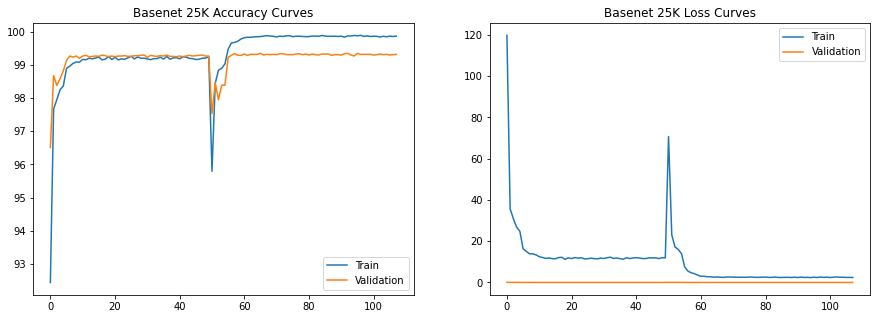

In [ ]:
plot_curves('Basenet 25K')

#### 1.5K ONE CYCLE LR

In [ ]:
epochs = 50
optimizer = optim.Adam(m.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=epochs)
path = './quantization/pytorch_model/1.5k_one_cycle.pth'

In [ ]:
execute_model(m, save_best_model=True)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.09385713934898376 Batch_id=468 Accuracy=95.64: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.1047, Accuracy: 9674/10000 (96.74%)

96.74 96.74
Saving model here
EPOCH: 1


Loss=0.10431339591741562 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.0696, Accuracy: 9765/10000 (97.65%)

97.65 97.65
Saving model here
EPOCH: 2


Loss=0.029705272987484932 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0827, Accuracy: 9746/10000 (97.46%)

97.65 97.46
EPOCH: 3


Loss=0.09929722547531128 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0633, Accuracy: 9791/10000 (97.91%)

97.91 97.91
Saving model here
EPOCH: 4


Loss=0.03752538934350014 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0963, Accuracy: 9704/10000 (97.04%)

97.91 97.04
EPOCH: 5


Loss=0.03874589130282402 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0642, Accuracy: 9803/10000 (98.03%)

98.03 98.03
Saving model here
EPOCH: 6


Loss=0.05910563841462135 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0549, Accuracy: 9826/10000 (98.26%)

98.26 98.26
Saving model here
EPOCH: 7


Loss=0.06552813202142715 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0643, Accuracy: 9814/10000 (98.14%)

98.26 98.14
EPOCH: 8


Loss=0.003482641652226448 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0748, Accuracy: 9757/10000 (97.57%)

98.26 97.57
EPOCH: 9


Loss=0.057568471878767014 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]



Test set: Average loss: 0.0584, Accuracy: 9817/10000 (98.17%)

98.26 98.17
EPOCH: 10


Loss=0.04158405959606171 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]



Test set: Average loss: 0.0506, Accuracy: 9843/10000 (98.43%)

98.43 98.43
Saving model here
EPOCH: 11


Loss=0.044068530201911926 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]



Test set: Average loss: 0.0497, Accuracy: 9843/10000 (98.43%)

98.43 98.43
Saving model here
EPOCH: 12


Loss=0.02702931873500347 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]



Test set: Average loss: 0.0449, Accuracy: 9854/10000 (98.54%)

98.54 98.54
Saving model here
EPOCH: 13


Loss=0.19608068466186523 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0468, Accuracy: 9857/10000 (98.57%)

98.57 98.57
Saving model here
EPOCH: 14


Loss=0.09502141922712326 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:19<00:00, 24.06it/s]



Test set: Average loss: 0.0459, Accuracy: 9860/10000 (98.60%)

98.6 98.6
Saving model here
EPOCH: 15


Loss=0.1847274750471115 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 0.0528, Accuracy: 9830/10000 (98.30%)

98.6 98.3
EPOCH: 16


Loss=0.017349306493997574 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]



Test set: Average loss: 0.0509, Accuracy: 9837/10000 (98.37%)

98.6 98.37
EPOCH: 17


Loss=0.06058394908905029 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]



Test set: Average loss: 0.0465, Accuracy: 9854/10000 (98.54%)

98.6 98.54
EPOCH: 18


Loss=0.04139604791998863 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]



Test set: Average loss: 0.0458, Accuracy: 9852/10000 (98.52%)

98.6 98.52
EPOCH: 19


Loss=0.06869810074567795 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.0452, Accuracy: 9855/10000 (98.55%)

98.6 98.55
EPOCH: 20


Loss=0.15161560475826263 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]



Test set: Average loss: 0.0434, Accuracy: 9860/10000 (98.60%)

98.6 98.6
Saving model here
EPOCH: 21


Loss=0.02581685222685337 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]



Test set: Average loss: 0.0594, Accuracy: 9819/10000 (98.19%)

98.6 98.19
EPOCH: 22


Loss=0.06287331134080887 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 0.0390, Accuracy: 9873/10000 (98.73%)

98.73 98.73
Saving model here
EPOCH: 23


Loss=0.010902014560997486 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]



Test set: Average loss: 0.0464, Accuracy: 9853/10000 (98.53%)

98.73 98.53
EPOCH: 24


Loss=0.040428802371025085 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]



Test set: Average loss: 0.0381, Accuracy: 9872/10000 (98.72%)

98.73 98.72
EPOCH: 25


Loss=0.03805513679981232 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]



Test set: Average loss: 0.0547, Accuracy: 9831/10000 (98.31%)

98.73 98.31
EPOCH: 26


Loss=0.02663888782262802 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]



Test set: Average loss: 0.0469, Accuracy: 9857/10000 (98.57%)

98.73 98.57
EPOCH: 27


Loss=0.024576576426625252 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]



Test set: Average loss: 0.0428, Accuracy: 9869/10000 (98.69%)

98.73 98.69
EPOCH: 28


Loss=0.08774302154779434 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0408, Accuracy: 9871/10000 (98.71%)

98.73 98.71
EPOCH: 29


Loss=0.02231641672551632 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]



Test set: Average loss: 0.0508, Accuracy: 9839/10000 (98.39%)

98.73 98.39
EPOCH: 30


Loss=0.054371997714042664 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]



Test set: Average loss: 0.0366, Accuracy: 9881/10000 (98.81%)

98.81 98.81
Saving model here
EPOCH: 31


Loss=0.05387061461806297 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]



Test set: Average loss: 0.0455, Accuracy: 9862/10000 (98.62%)

98.81 98.62
EPOCH: 32


Loss=0.06623388081789017 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]



Test set: Average loss: 0.0362, Accuracy: 9892/10000 (98.92%)

98.92 98.92
Saving model here
EPOCH: 33


Loss=0.00817026849836111 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]



Test set: Average loss: 0.0357, Accuracy: 9891/10000 (98.91%)

98.92 98.91
EPOCH: 34


Loss=0.016855401918292046 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]



Test set: Average loss: 0.0497, Accuracy: 9848/10000 (98.48%)

98.92 98.48
EPOCH: 35


Loss=0.004988791886717081 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0429, Accuracy: 9871/10000 (98.71%)

98.92 98.71
EPOCH: 36


Loss=0.0026717770379036665 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]



Test set: Average loss: 0.0419, Accuracy: 9866/10000 (98.66%)

98.92 98.66
EPOCH: 37


Loss=0.035886988043785095 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0461, Accuracy: 9858/10000 (98.58%)

98.92 98.58
EPOCH: 38


Loss=0.1082523986697197 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 0.0427, Accuracy: 9866/10000 (98.66%)

98.92 98.66
EPOCH: 39


Loss=0.08327525854110718 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]



Test set: Average loss: 0.0425, Accuracy: 9875/10000 (98.75%)

98.92 98.75
EPOCH: 40


Loss=0.01462333183735609 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0462, Accuracy: 9865/10000 (98.65%)

98.92 98.65
EPOCH: 41


Loss=0.03411365672945976 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0472, Accuracy: 9853/10000 (98.53%)

98.92 98.53
EPOCH: 42


Loss=0.1219724714756012 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]



Test set: Average loss: 0.0490, Accuracy: 9856/10000 (98.56%)

98.92 98.56
EPOCH: 43


Loss=0.039519596844911575 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]



Test set: Average loss: 0.0478, Accuracy: 9839/10000 (98.39%)

98.92 98.39
EPOCH: 44


Loss=0.14146682620048523 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]



Test set: Average loss: 0.0402, Accuracy: 9876/10000 (98.76%)

98.92 98.76
EPOCH: 45


Loss=0.0548822283744812 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]



Test set: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

98.92 98.86
EPOCH: 46


Loss=0.033068422228097916 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]



Test set: Average loss: 0.0447, Accuracy: 9867/10000 (98.67%)

98.92 98.67
EPOCH: 47


Loss=0.03411846235394478 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]



Test set: Average loss: 0.0479, Accuracy: 9854/10000 (98.54%)

98.92 98.54
EPOCH: 48


Loss=0.10830556601285934 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]



Test set: Average loss: 0.0413, Accuracy: 9872/10000 (98.72%)

98.92 98.72
EPOCH: 49


Loss=0.033116042613983154 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]



Test set: Average loss: 0.0436, Accuracy: 9869/10000 (98.69%)

98.92 98.69


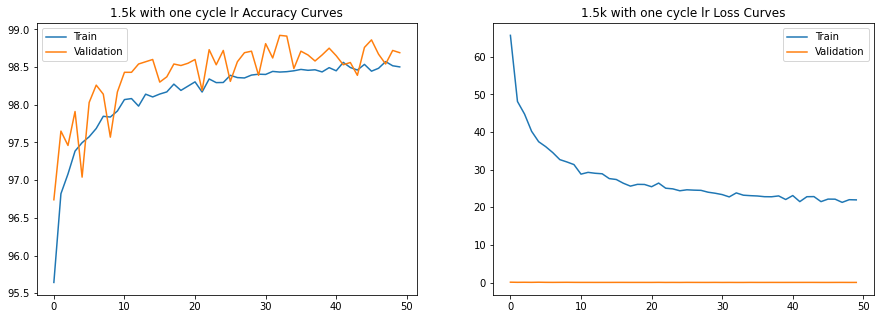

In [ ]:
plot_curves('1.5k with one cycle lr')

#### CIFARNET10

In [ ]:
class CifarNet11(nn.Module):
    def __init__(self):
        super(CifarNet11, self).__init__()

# FIRST MAJOR BLOCK
        # first convolutional block
        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels = 16,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.dropout1  = nn.Sequential(nn.Dropout(0.06))

        # Using stride 2 without dilation instead of maxpooling
        self.convpool1 = nn.MaxPool2d(2, 2)


# SECOND MAJOR BLOCK
          # first convolutional block
        self.convblock2a = nn.Sequential(
            # nn.Conv2d(in_channels = 16,out_channels = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),                    # in 16, out 16, RF ?
            nn.Conv2d(in_channels = 16,out_channels = 16,groups = 16, dilation  = 1,padding = 1,kernel_size= (3,3)),
            nn.Conv2d(in_channels = 16,out_channels = 32, dilation = 1,padding = 0,kernel_size= (1,1)), # 8, 8, 3  
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # will the learning will be better in depth wise or in normal 3x3 convolutions?

        self.convblock2b = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 32, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 16, out 16, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.dropout2  = nn.Sequential(nn.Dropout(0.07))

        # Using stride 2 without dilation to simulate max pooling
        self.convpool2 = nn.MaxPool2d(2, 2)

# THIRD MAJOR BLOCK
         # first convolutional block
        self.convblock3a = nn.Sequential(
            # nn.Conv2d(in_channels = 32,out_channels = 64, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 32,out_channels = 32,groups = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),        # in 8, out 8, RF ?
            nn.Conv2d(in_channels = 32,out_channels = 64, dilation = 1,padding = 0,kernel_size= (1,1)), # 8, 8, 3           # in 8, out 8, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.convblock3b = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 64, dilation  = 2,padding = 2, kernel_size= (3,3)),                     # in 8, out 8, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.dropout3  = nn.Sequential(nn.Dropout(0.07))
        # using dilation to simulate maxpooling
        self.convpool3 = nn.MaxPool2d(2, 2)

# FOURTH MAJOR BLOCK
        # second convolutional block
        self.convblock4a = nn.Sequential(
            # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 64,out_channels = 64, groups = 64, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4, RF ?
            nn.Conv2d(in_channels = 64,out_channels = 128, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.convblock4a1 = nn.Sequential(
            # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 128,out_channels = 128, groups = 128, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
            nn.Conv2d(in_channels = 128,out_channels = 192, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(192)
        )

        self.dropout4  = nn.Sequential(nn.Dropout(0.05))

        self.convblock4b = nn.Sequential(
            # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 192,out_channels = 192, groups = 192, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
            nn.Conv2d(in_channels = 192,out_channels = 260, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(260)
        )

        # self.convblock4b = nn.Sequential(
        #     # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
        #     nn.Conv2d(in_channels = 128,out_channels = 128, groups = 128, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
        #     nn.Conv2d(in_channels = 128,out_channels = 256, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256)
        # )

# GAP LAYER
        self.gap = nn.AvgPool2d(4)                                                                                          # in 3, out 1, RF ?
        self.convblockf = nn.Sequential(
            nn.Conv2d(in_channels=260, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


    def forward(self, x):
        x = self.convblock1a(x)
        x1 = self.convblock1b(x)
        x = torch.add(x,x1)
        x = self.dropout1(x)
        x = self.convpool1(x)


        x = self.convblock2a(x)
        x1 = self.convblock2b(x)
        x = torch.add(x,x1)
        x = self.dropout2(x)
        x = self.convpool2(x1)

        x = self.convblock3a(x)
        x1 = self.convblock3b(x)        
        x = torch.add(x,x1)
        x = self.dropout3(x)
        x = self.convpool3(x1)

        x = self.convblock4a(x)
        x = self.convblock4a1(x)
        x = self.dropout4(x)
        x = self.convblock4b(x)
        
        
        x = self.gap(x)
        x = self.convblockf(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
model = CifarNet11()


In [ ]:
class CifarNet11a(nn.Module):
    def __init__(self):
        super(CifarNet11a, self).__init__()

# FIRST MAJOR BLOCK
        # first convolutional block
        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels = 16,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.dropout1  = nn.Sequential(nn.Dropout(0.06))

        # Using stride 2 without dilation instead of maxpooling
        self.convpool1 = nn.MaxPool2d(2, 2)


# SECOND MAJOR BLOCK
          # first convolutional block
        self.convblock2a = nn.Sequential(
            nn.Conv2d(in_channels = 16,out_channels = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),                    # in 16, out 16, RF ? 
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # will the learning will be better in depth wise or in normal 3x3 convolutions?

        self.convblock2b = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 32, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 16, out 16, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.dropout2  = nn.Sequential(nn.Dropout(0.07))

        # Using stride 2 without dilation to simulate max pooling
        self.convpool2 = nn.MaxPool2d(2, 2)

# THIRD MAJOR BLOCK
         # first convolutional block
        self.convblock3a = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 64, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.convblock3b = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 64, dilation  = 2,padding = 2, kernel_size= (3,3)),                     # in 8, out 8, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.dropout3  = nn.Sequential(nn.Dropout(0.07))
        # using dilation to simulate maxpooling
        self.convpool3 = nn.MaxPool2d(2, 2)

# FOURTH MAJOR BLOCK
        # second convolutional block
        self.convblock4a = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 120, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.ReLU(),
            nn.BatchNorm2d(120)
        )
# GAP LAYER
        self.gap = nn.AvgPool2d(4)                                                                                          # in 3, out 1, RF ?
        self.convblockf = nn.Sequential(
            nn.Conv2d(in_channels=120, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1a(x)
        x1 = self.convblock1b(x)
        x = torch.add(x,x1)
        x = self.dropout1(x)
        x = self.convpool1(x)


        x = self.convblock2a(x)
        x1 = self.convblock2b(x)
        x = torch.add(x,x1)
        x = self.dropout2(x)
        x = self.convpool2(x1)

        x = self.convblock3a(x)
        x1 = self.convblock3b(x)        
        x = torch.add(x,x1)
        x = self.dropout3(x)
        x = self.convpool3(x1)

        x = self.convblock4a(x)
        x = self.gap(x)
        x = self.convblockf(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
model = CifarNet11a()

#### INFERENCE TIME EVALUATION

In [ ]:
path = './quantization/pytorch_model/normal_pytorch.pth'
model = Net()
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

time taken is 2.6732869148254395


In [ ]:
path = './quantization/pytorch_model/mosaic_7k_dw.pth'
model1 = Net1()
model1.load_state_dict(torch.load(path, map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(model1)

RuntimeError: ignored

In [ ]:
path = './quantization/pytorch_model/mosaic_7k_dw_new.pth'
model2 = Net1()
model2.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(model2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

time taken is 3.3572731018066406


In [ ]:
path = './quantization/pytorch_model/smallest_pytorch.pth'
smodel = SNet()
smodel.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(smodel)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.0484, Accuracy: 9835/10000 (98.35%)

time taken is 2.521306037902832


In [ ]:
path = './quantization/pytorch_model/small_pytorch.pth'
cmodel = CNet()
cmodel.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(cmodel)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

time taken is 2.762350559234619


In [ ]:
path = './quantization/pytorch_model/mosaic_5K_dw_new.pth'
cmodel = CNet1()
cmodel.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(cmodel)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

time taken is 2.747142791748047


In [ ]:
path = './quantization/pytorch_model/basenet25k.pth'
cmodel = BaseNet()
cmodel.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(cmodel)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

time taken is 3.368082046508789


In [ ]:
path = './mos_ml_cif_100/normal_pytorch_dw.pth'
# cmodel = BaseNet()
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(model)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.6639, Accuracy: 7990/10000 (79.90%)

time taken is 8.8280930519104


In [ ]:
path = './mos_ml_cif_100/normal_pytorch_wdw.pth'
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))  # Choose whatever GPU device number you want
test1(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.6477, Accuracy: 8157/10000 (81.57%)

time taken is 8.517145156860352
